In [1]:
import builtins
original_print = print
def custom_print(*args, **kwargs):
    new_args = []
    for arg in args:
        if isinstance(arg, float):
            new_args.append(f'{arg:.10f}')
        else:
            new_args.append(arg)
    original_print(*new_args, **kwargs)
builtins.print = custom_print

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
warnings.filterwarnings('ignore')

# Define the variable name for the unit power efficiency column
unit_power_efficiency = 'TH/J'

# Load the data for the maximum efficiency for all dates
max_efficiency_table = pd.read_csv('../hardwarelist/Bitcoin max updated2.csv')
max_efficiency_table['date'] = pd.to_datetime(max_efficiency_table['date'])

data = pd.read_csv('plotdata.csv') # date,row_index,hardware_name,TH/J,max_efficiency,year
data['date'] = pd.to_datetime(data['date'])
data = data[data['date'] >= '2013-01-01']

# econometrics

# Ensure that 'TH/J' is a numeric type
data['TH/J'] = pd.to_numeric(data['TH/J'], errors='coerce')
data['month'] = (data['date'] - timedelta(days=15)).dt.to_period('M')

# Group by 'month' and calculate the mean and standard deviation of 'TH/J'
monthly_data = data.groupby('month')['TH/J'].agg(['mean', 'std']).reset_index()
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# Create y_tilde
monthly_data['y_tilde'] = monthly_data['mean'] / monthly_data['std']

In [3]:
# impute nan in monthly_data['y_tilde'] with previous value
monthly_data['y_tilde'] = monthly_data['y_tilde'].fillna(method='ffill')

# impute inf in monthly_data['y_tilde'] with previous value
monthly_data['y_tilde'] = monthly_data['y_tilde'].replace(np.inf, np.nan).fillna(method='ffill')

Best ARIMA model order: (0, 1, 1)
Best ARIMA model AIC: 392.18322984147454
Best ARIMA model BIC: 397.5659256059328


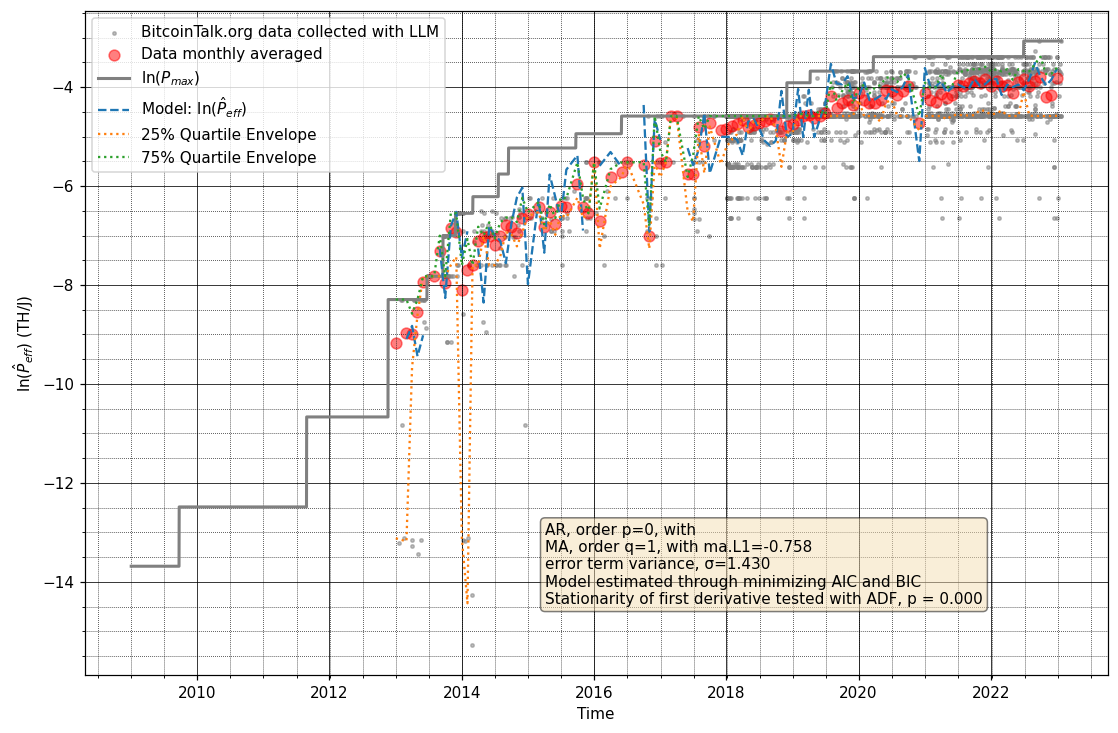

In [4]:


# Create the time variable t (in months)
monthly_data['t'] = np.arange(len(monthly_data)) + 1
monthly_data['t_squared'] = monthly_data['t'] ** 2

# Get the maximum power efficiency over time
def get_max_efficiency(date):
    date = str(date)[:10]
    try:
        return max_efficiency_table[max_efficiency_table['date'] == date]['max (TH/J)'].values[0]
    except:
        return -1
monthly_data['P_max_t'] = monthly_data['month'].apply(lambda x: get_max_efficiency(x))
monthly_data['log_P_max_t'] = np.log(monthly_data['P_max_t'])
monthly_data['t'] = monthly_data['t'].astype(float)

# Define the range of lags to test for the AR and MA components
p_range = range(0, 5)  # AR component
q_range = range(0, 5)  # MA component

best_aic = np.inf
best_bic = np.inf
best_order = None
best_model_fit = None

# Loop over the range of p and q values
for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(monthly_data['y_tilde'], order=(p, 1, q))
            model_fit = model.fit()
            if model_fit.aic < best_aic or model_fit.bic < best_bic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_order = (p, 1, q)
                best_model_fit = model_fit
        except Exception as e:
            print(f"ARIMA({p},0,{q}) - Model failed to fit: {e}")

# Print the best model's AIC, BIC, and order
print(f"Best ARIMA model order: {best_order}")
print(f"Best ARIMA model AIC: {best_aic}")
print(f"Best ARIMA model BIC: {best_bic}")

# Calculate y_hat from y_tilde
monthly_data['y_hat'] = best_model_fit.fittedvalues * monthly_data['std']

# Calculate the 25% and 75% quartiles for each month
monthly_data['25%'] = data.groupby('month')['TH/J'].quantile(0.25).reset_index()['TH/J']
monthly_data['75%'] = data.groupby('month')['TH/J'].quantile(0.75).reset_index()['TH/J']

# Create new columns for the 25% and 75% quartiles divided by the standard deviation
monthly_data['25%_tilde'] = monthly_data['25%'] / monthly_data['std']
monthly_data['75%_tilde'] = monthly_data['75%'] / monthly_data['std']

# Plotting code with quartile envelopes
dpi = 110
plt.figure(figsize=(12, 8), dpi=dpi)
plt.scatter(data['date'], np.log(data[unit_power_efficiency]), c='gray', s=5, label='BitcoinTalk.org data collected with LLM', alpha=0.5)
plt.scatter(monthly_data['month'], np.log(monthly_data['mean']), c='red', s=50, label='Data monthly averaged', alpha=0.5)
plt.plot(max_efficiency_table['date'], np.log(max_efficiency_table['max (TH/J)']), color='gray', label='ln($P_{max}$)', linewidth=2)
plt.plot(monthly_data['month'][1:], np.log(monthly_data['y_hat'][1:]), label='Model: ln($\hat{P}_{eff}$)', linestyle='--')
plt.plot(monthly_data['month'], np.log(monthly_data['25%']), label='25% Quartile Envelope', linestyle=':')
plt.plot(monthly_data['month'], np.log(monthly_data['75%']), label='75% Quartile Envelope', linestyle=':')
plt.xlabel('Time')
plt.ylabel('ln($\hat{P}_{eff}$) (TH/J)')
plt.yscale('linear')
plt.legend()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.minorticks_on()

# Update the box with model details
params = best_model_fit.params
ar_params = ', '.join([f'ar.L{i}={params[f"ar.L{i}"]:.3f}' for i in range(1, best_order[0]+1)])
ma_params = ', '.join([f'ma.L{i}={params[f"ma.L{i}"]:.3f}' for i in range(1, best_order[2]+1)])
sigma = params['sigma2']**0.5

textstr = '\n'.join((
    # f'formula:',
    # r'$\tilde{y}_{t}$ = ar.L1 * $\tilde{y}_{t-1}$ + ar.L2 * $\tilde{y}_{t-2}$ + ma.L1 * $ε_{t-1}$ + ε_t',
    f'AR, order p={best_order[0]}, with {ar_params}',
    f'MA, order q={best_order[2]}, with {ma_params}',
    f'error term variance, σ={sigma:.3f}',
    f'Model estimated through minimizing AIC and BIC',
    f'Stationarity of first derivative tested with ADF, p = 0.000',
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.45, 0.23, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.show()

In [ ]:
# import pandas as pd

# max_efficiency_table = pd.read_csv('../hardwarelist/Bitcoin max updated2.csv')

# # Assuming the 'Date' column in max_efficiency_table is in a format that can be converted to datetime
# max_efficiency_table['date'] = pd.to_datetime(max_efficiency_table['date'])

# data = pd.read_csv('datasets/extracted/final3.csv')
# data["date"] = data["date"].apply(lambda x: x[:10])
# data2 = pd.read_csv('datasets/extracted/pre_2018.csv')
# data = pd.concat([data2[["date","row_index","hardware_name","TH/J"]], data[["date","row_index","hardware_name","TH/J"]]])

# def get_max_efficiency(date):
#     date = str(date)[:10]
#     try:
#         return max_efficiency_table[max_efficiency_table['date'] == date]['max (TH/J)'].values[0]
#     except:
#         return -1
    

# # delete rows where TH/J is larger than the max efficiency for that date
# data['max_efficiency'] = data['date'].apply(lambda x: get_max_efficiency(x))
# data = data[data['TH/J'] <= data['max_efficiency']*1.01]

# data.to_csv('datasets/extracted/merged.csv', index=False)

# # Convert the 'date' column to a datetime format
# data['date'] = pd.to_datetime(data['date'])

# # Extract year from the 'date' column and create a new column 'year'
# data['year'] = data['date'].dt.year

# data.to_csv('plotdata.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
warnings.filterwarnings('ignore')

# Define the variable name for the unit power efficiency column
unit_power_efficiency = 'TH/J'

# Load the data for the maximum efficiency for all dates
max_efficiency_table = pd.read_csv('../hardwarelist/Bitcoin max updated2.csv')

# Assuming the 'Date' column in max_efficiency_table is in a format that can be converted to datetime
max_efficiency_table['date'] = pd.to_datetime(max_efficiency_table['date'])

data = pd.read_csv('plotdata.csv') # date,row_index,hardware_name,TH/J,max_efficiency,year

# Convert the 'date' column to a datetime format
data['date'] = pd.to_datetime(data['date'])

# keep only data from 2013 onwards
data = data[data['date'] >= '2013-01-01']

# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

# # Extract years from the data
# years = data['year'].unique()

# # Initialize lists to store yearly 'TH/J' values
# th_j_values = []

# # Create an empty array to store the regression lines
# regression_lines = []

# # Iterate over each year, calculate the slope, and store the data
# for year in years:
#     # Filter data for the current year
#     yearly_data = data[data['year'] == year]

#     # Calculate the mean 'TH/J' value for the year
#     th_j_mean = yearly_data[unit_power_efficiency].mean()

#     # Store the yearly 'TH/J' value
#     th_j_values.append(th_j_mean)

#     # Store the regression line for the year (point at the end of the year)
#     end_of_year_date = yearly_data['date'].max()
#     regression_lines.append((end_of_year_date, th_j_mean))

# # Create a DataFrame to store the yearly 'TH/J' values and regression points
# results = pd.DataFrame({'Year': years, unit_power_efficiency: th_j_values})

# plt.rcParams['font.family'] = 'Times New Roman'

# # Scatter plot for all data points
# plt.scatter(data['date'], data[unit_power_efficiency], c='gray', s=5, label='Data Points', alpha=0.5)

# # Plot the regression lines (one point per year)
# regression_dates, regression_th_j_values = zip(*regression_lines)
# plt.plot(regression_dates, regression_th_j_values, marker='o', linestyle='-', color='black', label=f'Yearly {unit_power_efficiency} Regression')

# # Plot the Hardware (TH/J) line
# plt.plot(max_efficiency_table['date'], max_efficiency_table['max (TH/J)'], color='gray', label='Max possible (TH/J)', linewidth=2)

# plt.yscale('log')  # Set the y-axis to a logarithmic scale base 10


# plt.xlabel('Date', fontname='Times New Roman', fontsize=12)
# plt.ylabel('Power Efficiency (' + unit_power_efficiency + ')', fontname='Times New Roman')
# # plt.title(f'Yearly-Updated {unit_power_efficiency} with Data Points and Max Efficiency', fontname='Times New Roman')
# plt.legend(loc='upper left')

# # Enable minor ticks
# plt.minorticks_on()

# # Add major grid to the plot
# plt.grid(True, which='major', axis='both', linestyle='-', linewidth=0.5, color='gray', alpha=0.7)

# # Add minor grid to the plot with a lighter style
# plt.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.25, color='gray', alpha=0.7)

# plt.yticks()

# plt.savefig('high_res_plot.png', dpi=300)
# plt.show()

In [ ]:
# econometrics

# Step 1: Average the data points on a monthly basis
# Ensure that 'TH/J' is a numeric type
data['TH/J'] = pd.to_numeric(data['TH/J'], errors='coerce')

# Create a 'month' column by offsetting the 'date' by 15 days and then using to_period
data['month'] = (data['date'] - timedelta(days=15)).dt.to_period('M')

# Group by 'month' and calculate the mean of 'TH/J'
monthly_data = data.groupby('month')['TH/J'].mean().reset_index()

# Convert 'month' back to datetime (first day of the month)
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# Step 2: Create a time series for power efficiency
# Create the time variable t (in months)
monthly_data['t'] = np.arange(len(monthly_data))+1

# Then, create t^2
monthly_data['t_squared'] = monthly_data['t'] ** 2

# Get the maximum power efficiency over time
def get_max_efficiency(date):
    date = str(date)[:10]
    try:
        return max_efficiency_table[max_efficiency_table['date'] == date]['max (TH/J)'].values[0]
    except:
        return -1
monthly_data['P_max_t'] = monthly_data['month'].apply(lambda x: get_max_efficiency(x))

# Create the log of P_max_t
monthly_data['log_P_max_t'] = np.log(monthly_data['P_max_t'])

# Convert 't' to float to avoid issues with negative powers
monthly_data['t'] = monthly_data['t'].astype(float)

# Define the range of lags to test for the AR and MA components
p_range = range(1, 11)  # AR component
q_range = range(1, 11)  # MA component

best_aic = np.inf
best_bic = np.inf
best_order = None
best_model_fit = None

# Loop over the range of p and q values
for p in p_range:
    for q in q_range:
        try:
            # Fit the ARIMA model with the current p and q values
            model = ARIMA(monthly_data['TH/J'], order=(p, 1, q))
            model_fit = model.fit()
            
            # Check if the current model has a lower AIC or BIC than the best one found so far
            if model_fit.aic < best_aic or model_fit.bic < best_bic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_order = (p, 1, q)
                best_model_fit = model_fit
        except Exception as e:
            print(f"ARIMA({p},0,{q}) - Model failed to fit: {e}")

# Print the best model's AIC, BIC, and order
print(f"Best ARIMA model order: {best_order}")
print(f"Best ARIMA model AIC: {best_aic}")
print(f"Best ARIMA model BIC: {best_bic}")



In [ ]:
# Extract the parameter values from the best model fit
params = best_model_fit.params
param_str = ', '.join([f'{key}={value:.3f}' for key, value in params.items()])

dpi = 110

# Step 4: Plot single point for each month + all the data points using the best model
plt.figure(figsize=(12, 8), dpi=dpi)
plt.scatter(data['date'], np.log(data[unit_power_efficiency]), c='gray', s=5, label='BitcoinTalk.org data collected with LLM', alpha=0.5)
plt.scatter(monthly_data['month'], np.log(monthly_data['TH/J']), c='red', s=50, label='Data monthly averaged', alpha=0.5)
plt.plot(max_efficiency_table['date'], np.log(max_efficiency_table['max (TH/J)']), color='gray', label='ln($P_{max}$)', linewidth=2)
plt.plot(monthly_data['month'][1:], np.log(best_model_fit.fittedvalues[1:]), label='Model: ln($\hat{P}_{eff}$)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('ln($\hat{P}_{eff}$) (TH/J)')
plt.yscale('linear')
plt.legend()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.minorticks_on()

# Update the box with model details
ar_params = ', '.join([f'ar.L{i}={params[f"ar.L{i}"]:.3f}' for i in range(1, best_order[0]+1)])
ma_params = ', '.join([f'ma.L{i}={params[f"ma.L{i}"]:.3f}' for i in range(1, best_order[2]+1)])
sigma = params['sigma2']**0.5

textstr = '\n'.join((
    f'formula:',
    r'ln($\hat{P}_{eff_t}$) = ar.L1 * ln($\hat{P}_{eff_{t-1}}$) + ar.L2 * ln($\hat{P}_{eff_{t-2}}$) + ma.L1 * $ε_{t-1}$ + ε_t',
    f'AR, order p={best_order[0]}, with {ar_params}',
    f'MA, order q={best_order[2]}, with {ma_params}',
    f'error term variance, σ={sigma:.3f}',
    f'Model estimated through minimizing AIC and BIC',
    f'Stationarity of first derivative tested with ADF, p = 0.000',
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# Adjust the position of the box to be next to the plot
plt.gca().text(0.45, 0.23, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.show()

# Step 5: Plot P_eff,t(t) + Single point for each month, excluding the first month from the fitted line using the best model
plt.figure(figsize=(12, 8), dpi=dpi)
# Exclude the first month from the fitted values line
plt.plot(monthly_data['month'][1:], best_model_fit.fittedvalues[1:], label='Fitted Values (Best Model)')
plt.scatter(monthly_data['month'], monthly_data['TH/J'], c='red', s=50, label='Monthly Average', alpha=0.5)
plt.plot(max_efficiency_table['date'], max_efficiency_table['max (TH/J)'], color='gray', label='Max possible (TH/J)', linewidth=2)
plt.yscale('log')
plt.legend()
plt.show()

# Step 6: Plot with just the residual term using the best model
plt.figure(figsize=(12, 8), dpi=dpi)
plt.plot(monthly_data['month'], best_model_fit.resid, label='Residuals (Best Model)')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# Create a DataFrame with the model's fitted values
model_values_df = pd.DataFrame({
    'month': monthly_data['month'][1:],  # Exclude the first month as it doesn't have a fitted value
    'model_value': best_model_fit.fittedvalues[1:]
})
model_values_df

In [ ]:


# Merge the model_values_df with monthly_data
# Note: Ensure that both DataFrames have the 'date' column in the same format for a successful merge
combined_data = pd.merge(monthly_data, model_values_df, how='left', left_on='month', right_on='month')

# Drop the additional 'date' column from the merge, if needed
# combined_data.drop('month', axis=1, inplace=True)

# Export the combined_data DataFrame to a CSV file
combined_data.to_csv('model_and_monthly_data.csv', index=False)

In [ ]:
print(param_str)

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(monthly_data['TH/J'].dropna())

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result[1] < 0.05:
    print("The time series is stationary with 95% confidence.")
else:
    print("The time series is not stationary with 95% confidence.")

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Calculate the first derivative of the time series
monthly_data['TH/J_diff'] = monthly_data['TH/J'].diff()

# Drop the first row since it will be NaN after differencing
monthly_data_diff = monthly_data.dropna(subset=['TH/J_diff'])

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(monthly_data_diff['TH/J_diff'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if adf_result[1] < 0.05:
    print("The first derivative of the time series is stationary.")
else:
    print("The first derivative of the time series is not stationary.")

In [ ]:
param_str

In [ ]:
# # looks like:
# # [
# #  (Timestamp('2011-08-04 00:00:00'), 1.9952745454545455e-06),
# #  (Timestamp('2012-12-31 00:00:00'), 3.2042489473684216e-05),
# #  (Timestamp('2013-12-21 00:00:00'), 0.0005635879322033898)
# # ]
# regression_lines

In [ ]:
# df = pd.DataFrame(columns=['date', 'max possible', 'archaicity', 'max found', 'regression'])
# df['date'] = max_efficiency_table['date']
# df['max possible'] = max_efficiency_table['max (TH/J)']
# df['archaicity'] = max_efficiency_table['archaicity (TH/J)']


# # finds the 2 closest timestamps in regression_lines and returns the interpolated value
# def get_regression(date):
#     closest_smaller_timestamp_index = None
#     closest_larger_timestamp_index = None
#     for (i,(timestamp, value)) in enumerate(regression_lines):
#         if timestamp <= date:
#             closest_smaller_timestamp_index = i
#         else:
#             closest_larger_timestamp_index = i
#             break
    
#     if closest_smaller_timestamp_index is None:
#         return regression_lines[0][1]
#     elif closest_larger_timestamp_index is None:
#         return regression_lines[-1][1]
    
#     smaller_value = regression_lines[closest_smaller_timestamp_index][1]
#     larger_value = regression_lines[closest_larger_timestamp_index][1]

#     # interpolate
#     return smaller_value + (larger_value - smaller_value) * (date - regression_lines[closest_smaller_timestamp_index][0]) / (regression_lines[closest_larger_timestamp_index][0] - regression_lines[closest_smaller_timestamp_index][0])

     
# df['regression'] = df['date'].apply(get_regression)

# # gets the max efficiency for a given date from the data table
# def get_max_efficiency(date):
#     return data[data['date'] == date][unit_power_efficiency].max()

# df['max found'] = df['date'].apply(get_max_efficiency)

In [ ]:
# df.sample(30)

In [ ]:
# df.to_csv('plot.csv', index=False)